## Goals
Construct an algorithm that, for each Country:

1. Removes the seasonal component in the time-series (if a seasonal component is present);
2. predicts if the non-seasonal component of sales is increasing or not.
That is the prediction is binary: value=1 if the non-seasonal component is increasing; value=0 if the non-seasonal component is not increasing.

Remarks

1. Some time-series may not have a seasonal component. At low latitudes, there is not significant seasonal change.
2. The original time-series duration is unknown. Time is assumed to be normalised into the interval [0,1] (100 evenly spaced numbers in the interval [0,1])


## Ideas to improve baseline

1. Adding another non-linear basis function components (e.g., $tanh(w0+w1x)$) and seeing if you can better split the seasonal and non-seasonal component.
2. In the second example, the sin/cos basis function fits the nonlinear function, but it is clear that the obtained mean function is non-periodic. By definition a function is periodic in the interval [0,1] if you see at least one full cycle (e.g. $cos(\pi x)$ is not peridic in [0,1] but $cos(2 \pi x)$ is). So you could try to verify if the function is periodic or not. In case it is periodic you can use "non_periodic_prediction" for checking if the function is increasing or not. Instead, if the function is not periodic that you could use  "all_prediction" for checking if the function is increasing or not. How can you test if a function is periodic or not given your basis functions in H ?
3. The baseline model computes the derivative of the non-seasonal component and checks if the derivative is non-negative for all $x\in[0,1]$ as a way to assess if sales are increasing. Could an analytical derivative work better in the above case?
4. You could try to use GPs
5. Is the decision criterion "posterior_probability_deriviative_is_positive>0.95" the best way to make decisions? Maybe you would do better if you take into account the way weighted accuracy is defined for this competition.

Import the data and display the header

In [144]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x = np.linspace(0,1,100)
test_df = pd.read_csv("Dataset/test.csv")
train_df = pd.read_csv("Dataset/train.csv")

In [145]:
train_df.head()

Id         0         1         2         3         4         5         6  \
0  120  0.147298 -0.142030  0.091737 -0.151707  0.060124  0.186191 -0.021298   
1  121  0.115710  0.105061  0.038446  0.166711 -0.113913  0.004528 -0.006954   
2  122 -0.548826 -0.466551 -0.650890 -0.553450 -0.449101 -0.496902 -0.464860   
3  123  0.192618  0.291155 -0.042980  0.146483  0.015390  0.019394 -0.005577   
4  124  0.075706  0.069045 -0.019818  0.068801 -0.226501  0.011658  0.087905   

          7         8  ...        91        92        93        94        95  \
0 -0.025636  0.061044  ... -0.218118  0.011316  0.079464 -0.010833 -0.053485   
1 -0.140054  0.154231  ...  0.021526  0.069009 -0.060343  0.094007  0.049558   
2 -0.394458 -0.271801  ...  0.057272  0.088062 -0.069730  0.168498  0.109672   
3 -0.048682  0.025772  ...  0.140831  0.257332  0.262786  0.351659  0.213291   
4 -0.080787 -0.080369  ...  0.434803  0.322841  0.297772  0.461421  0.406143   

         96        97        98        99  Category  
0  0.046450 -0.008333  0.168574  0.123273         0  
1  0.112370  0.020398  0.039687  0.217384         0  
2  0.202808 -0.019942  0.058902  0.053936         0  
3  0.251077  0.190920  0.251743  0.337730         1  
4  0.562082  0.554588  0.471489  0.384229         1  

[5 rows x 102 columns]

In [146]:
print(train_df['Category'])

0     0
1     0
2     0
3     1
4     1
     ..
70    0
71    0
72    0
73    0
74    0
Name: Category, Length: 75, dtype: int64


Example of data

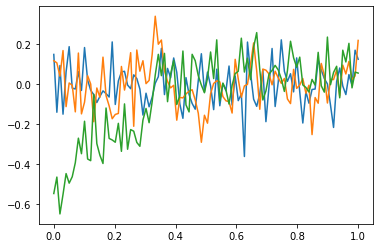

In [147]:
#print((train_df.iloc[:,1:-1].shape[0]))

x = np.linspace(0,1,train_df.iloc[:,1:-1].shape[1])

plt.plot(x, train_df.iloc[:,1:-1].iloc[0,:])
plt.plot(x, train_df.iloc[:,1:-1].iloc[1,:])
plt.plot(x, train_df.iloc[:,1:-1].iloc[2,:])

Plot the original data for all countries

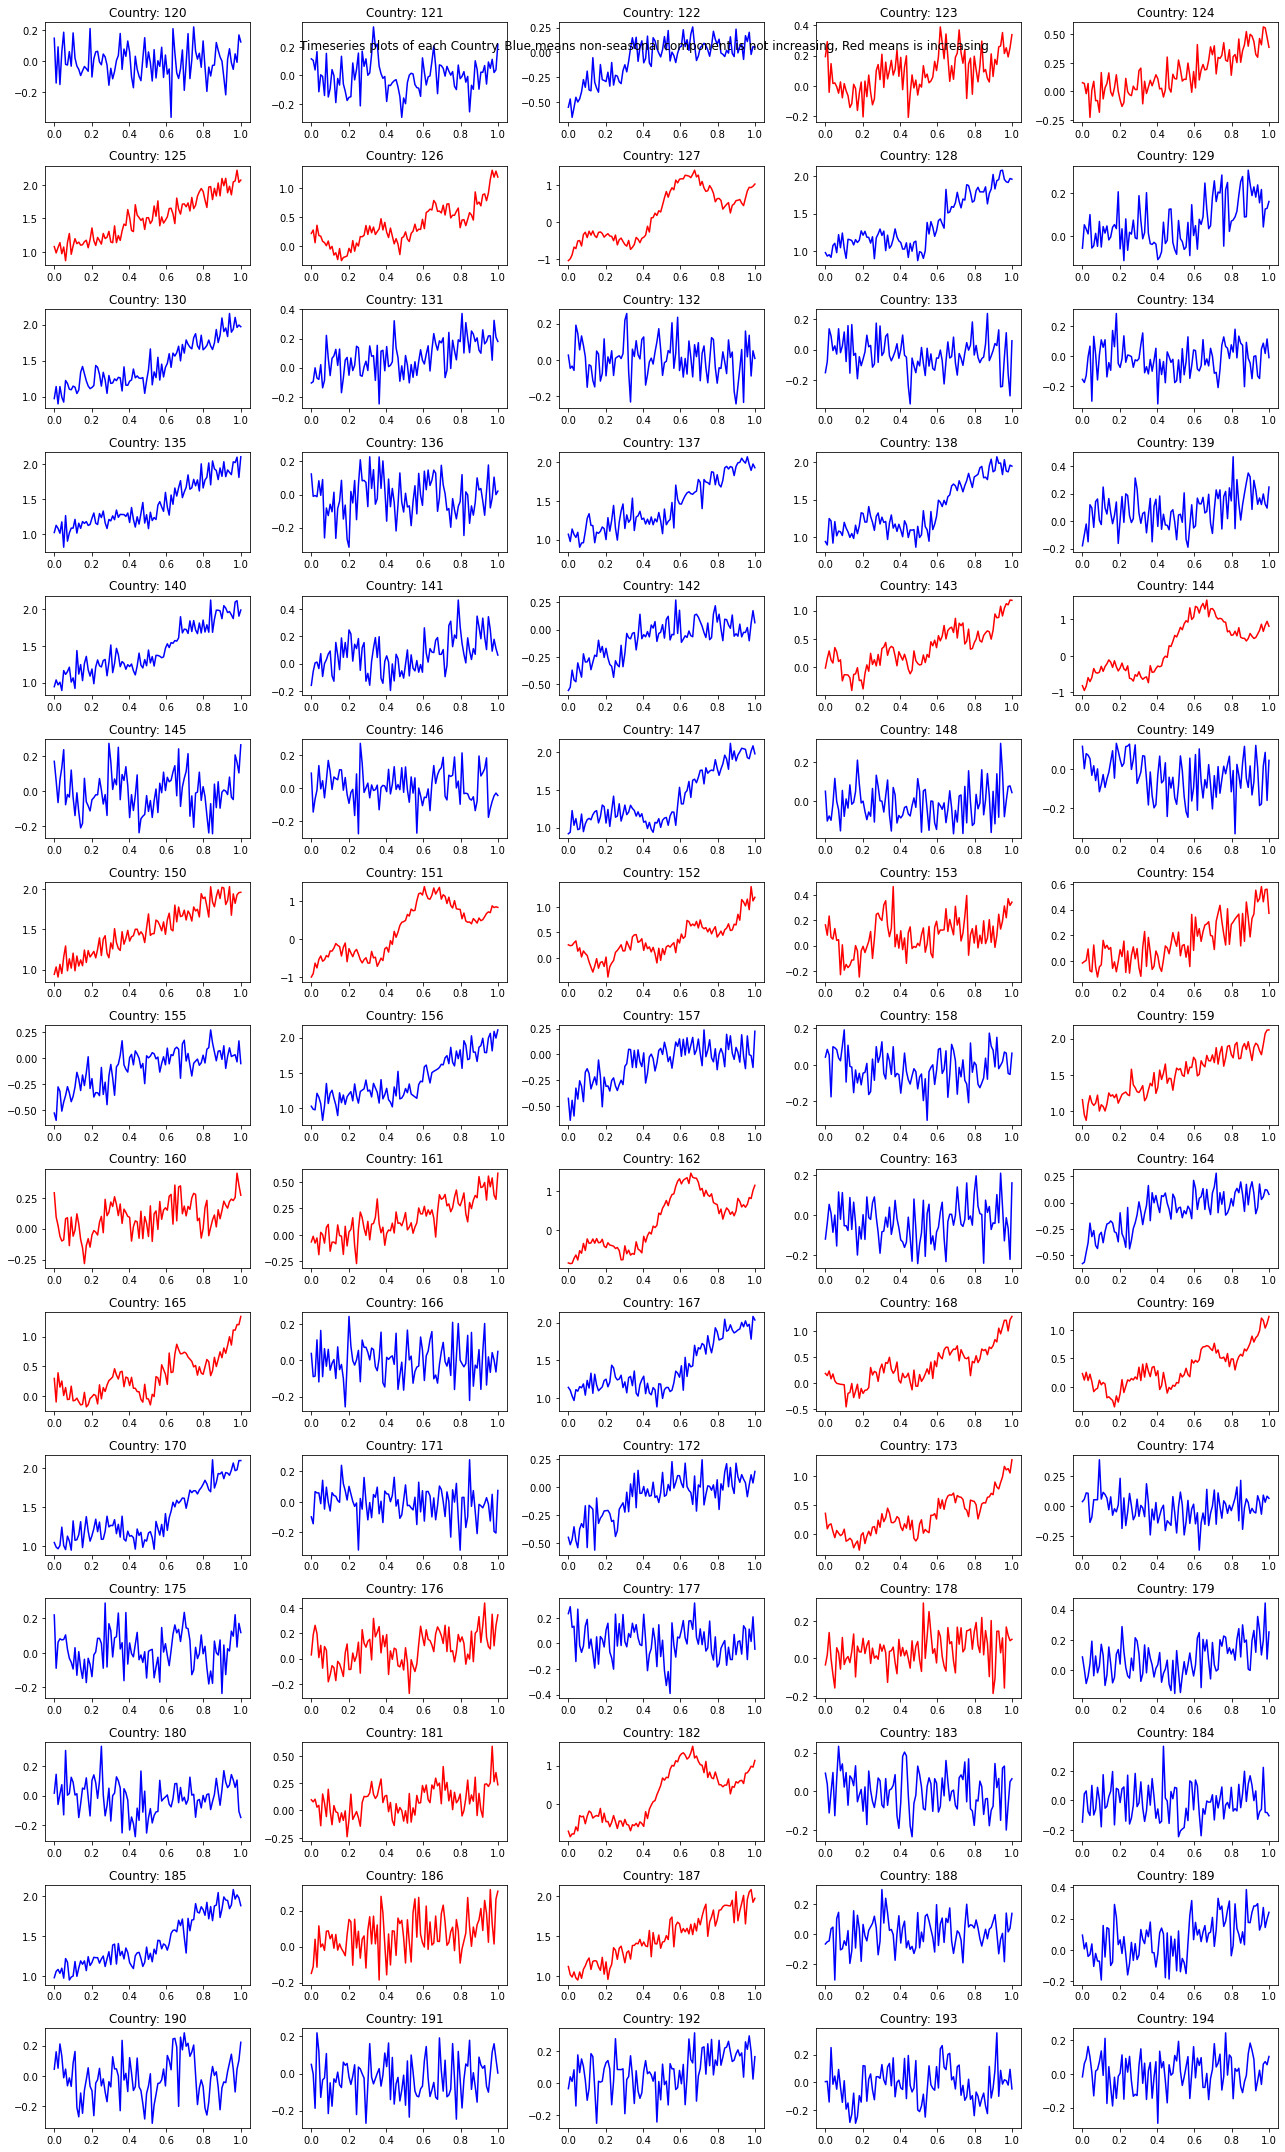

In [148]:
plot_num_cols = 5
fig, axs = plt.subplots(nrows=15, ncols=plot_num_cols, figsize=(18, 30))
axs = axs.flat # so only 1 for loop

num_rows = train_df.iloc[:,1:-1].shape[0]
rows = range(0, num_rows)


for ax, i in zip(axs, rows):
    plt_col = i % plot_num_cols
    plt_row = i - plt_col
    ax.set_title(f'Country: {i + 120}')
    c = 'blue' if (train_df.iloc[i,-1:]['Category'] < 0.5) else 'red'
    
    ax.plot(x, train_df.iloc[:,1:-1].iloc[i,:], color=c)

plt.tight_layout()
plt.suptitle("Timeseries plots of each Country. Blue means non-seasonal component is not increasing, Red means is increasing")
plt.show()

In [149]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

#define  basis functions
def make_basis(x):
    # the components are 1,x, cos(2 \pi x), sin(2 \pi x)...
    #periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.tan(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.tan(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.tan(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.tan(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.tan(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x),np.tan(12*np.pi*x)])
    return np.hstack([np.ones((x.shape[0],1)),x, periodic ]) 

#  periodic basis starts at column:
col_per = 2

#baseline model
def run_model(x,y,plot=False):    
    H = make_basis(x.reshape(-1,1))
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    H_np = H[:,0:col_per]

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    all_prediction = np.dot(H,posterior['weights'].T).T
    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T
    if plot==True:
        plt.figure()
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)
    Gradients = []
    for i in range(non_periodic_prediction.shape[0]):
        Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))
        
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print("probability that the function is increasing=", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        return 1
    else:
        return 0

    
#this is the inpu
x = np.linspace(0,1,100)    

In [150]:
#from scipy.stats import multivariate_normal
#Decision = pd.DataFrame(columns=['Id','Category'])
#for r in range(train_df.shape[0]):
#for r in range(train_df.shape[0]):
#    id_row = test_df.iloc[r,0]
#    y = test_df.iloc[r,1:].values
#    decision = run_model(x,y)
#    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
#    print(Decision)
#    Decision.to_csv("Decision_baseline.csv",  index=False)

#y_n = (y -np.mean(y))/np.std(y)
#X_n = (x-np.mean(x))/np.std(x)

#X_n = np.reshape(X_n,(-1,1))
#y_n = np.reshape(y_n,(-1,1))

In [151]:
from scipy.stats import multivariate_normal
Decision = pd.DataFrame(columns=['Id','Category'])
y = []


for r in range(train_df.shape[0]):
#for r in range(15):
    id_row = test_df.iloc[r,0]
    y.append(test_df.iloc[r,1:].values)
    decision = run_model(x,y)
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
    #Decision.to_csv("Decision_baseline.csv",  index=False)

Finished [100%]: Average Loss = 182.8


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 421.48


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 567.77


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 713.44


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 852.58


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 986.66


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 1,125.6


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 1,269.3


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 1,411.3


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 1,533.9


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 1,676.2


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 1,813.3


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 1,941.7


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 2,086.1


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 2,231.5


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 2,374.6


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 2,514.2


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 2,653.6


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 2,792.7


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 2,928.6


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 3,069.7


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 3,212.6


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 3,355.5


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 3,494.9


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 3,633.5


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 3,776.7


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 3,915.4


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 4,057


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 4,182.7


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 4,333.1


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 4,479


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 4,615.2


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 4,759


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 4,901.1


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 5,038


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 5,179.1


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 5,317.2


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 5,460.6


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 5,598


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 5,740.5


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 5,880.5


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 6,022.9


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 6,164.1


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 6,307.7


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 6,439.3


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 6,577.6


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 6,718.1


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 6,856.1


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 6,997.2


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 7,134.6


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 7,259.9


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 7,398.8


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 7,539


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 7,681.8


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 7,806.3


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 7,946.6


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 8,087.6


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 8,227.2


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 8,365.9


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 8,503.7


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 8,641.1


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 8,764.8


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 8,904.3


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 9,047.3


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 9,190


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 9,312.8


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 9,452.1


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 9,591.3


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 9,734.6


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 9,872.1


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 10,011


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 10,152


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 10,297


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 10,436


probability that the function is increasing= 1.0


Finished [100%]: Average Loss = 10,575


probability that the function is increasing= 1.0


In [152]:
y_n=[]
for i in range(len(y)):
    y_nn = (y[i] -np.mean(y[i]))/np.std(y[i])
    y_n.append(np.reshape(y_nn,(-1,1)))
    #ax.plot(x, train_time_series_df.iloc[i,:], color=c)
    
X_n = (x-np.mean(x))/np.std(x)
X_n = np.reshape(X_n,(-1,1))
#y_n = np.reshape(y_n,(-1,1))

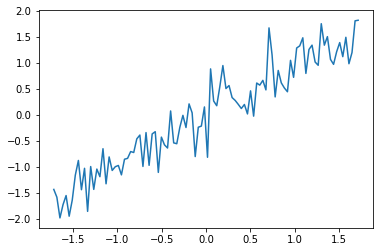

In [153]:
#print(y_n)
#print(X_n)
#print(y[0])

plt.plot(X_n,y_n[0])

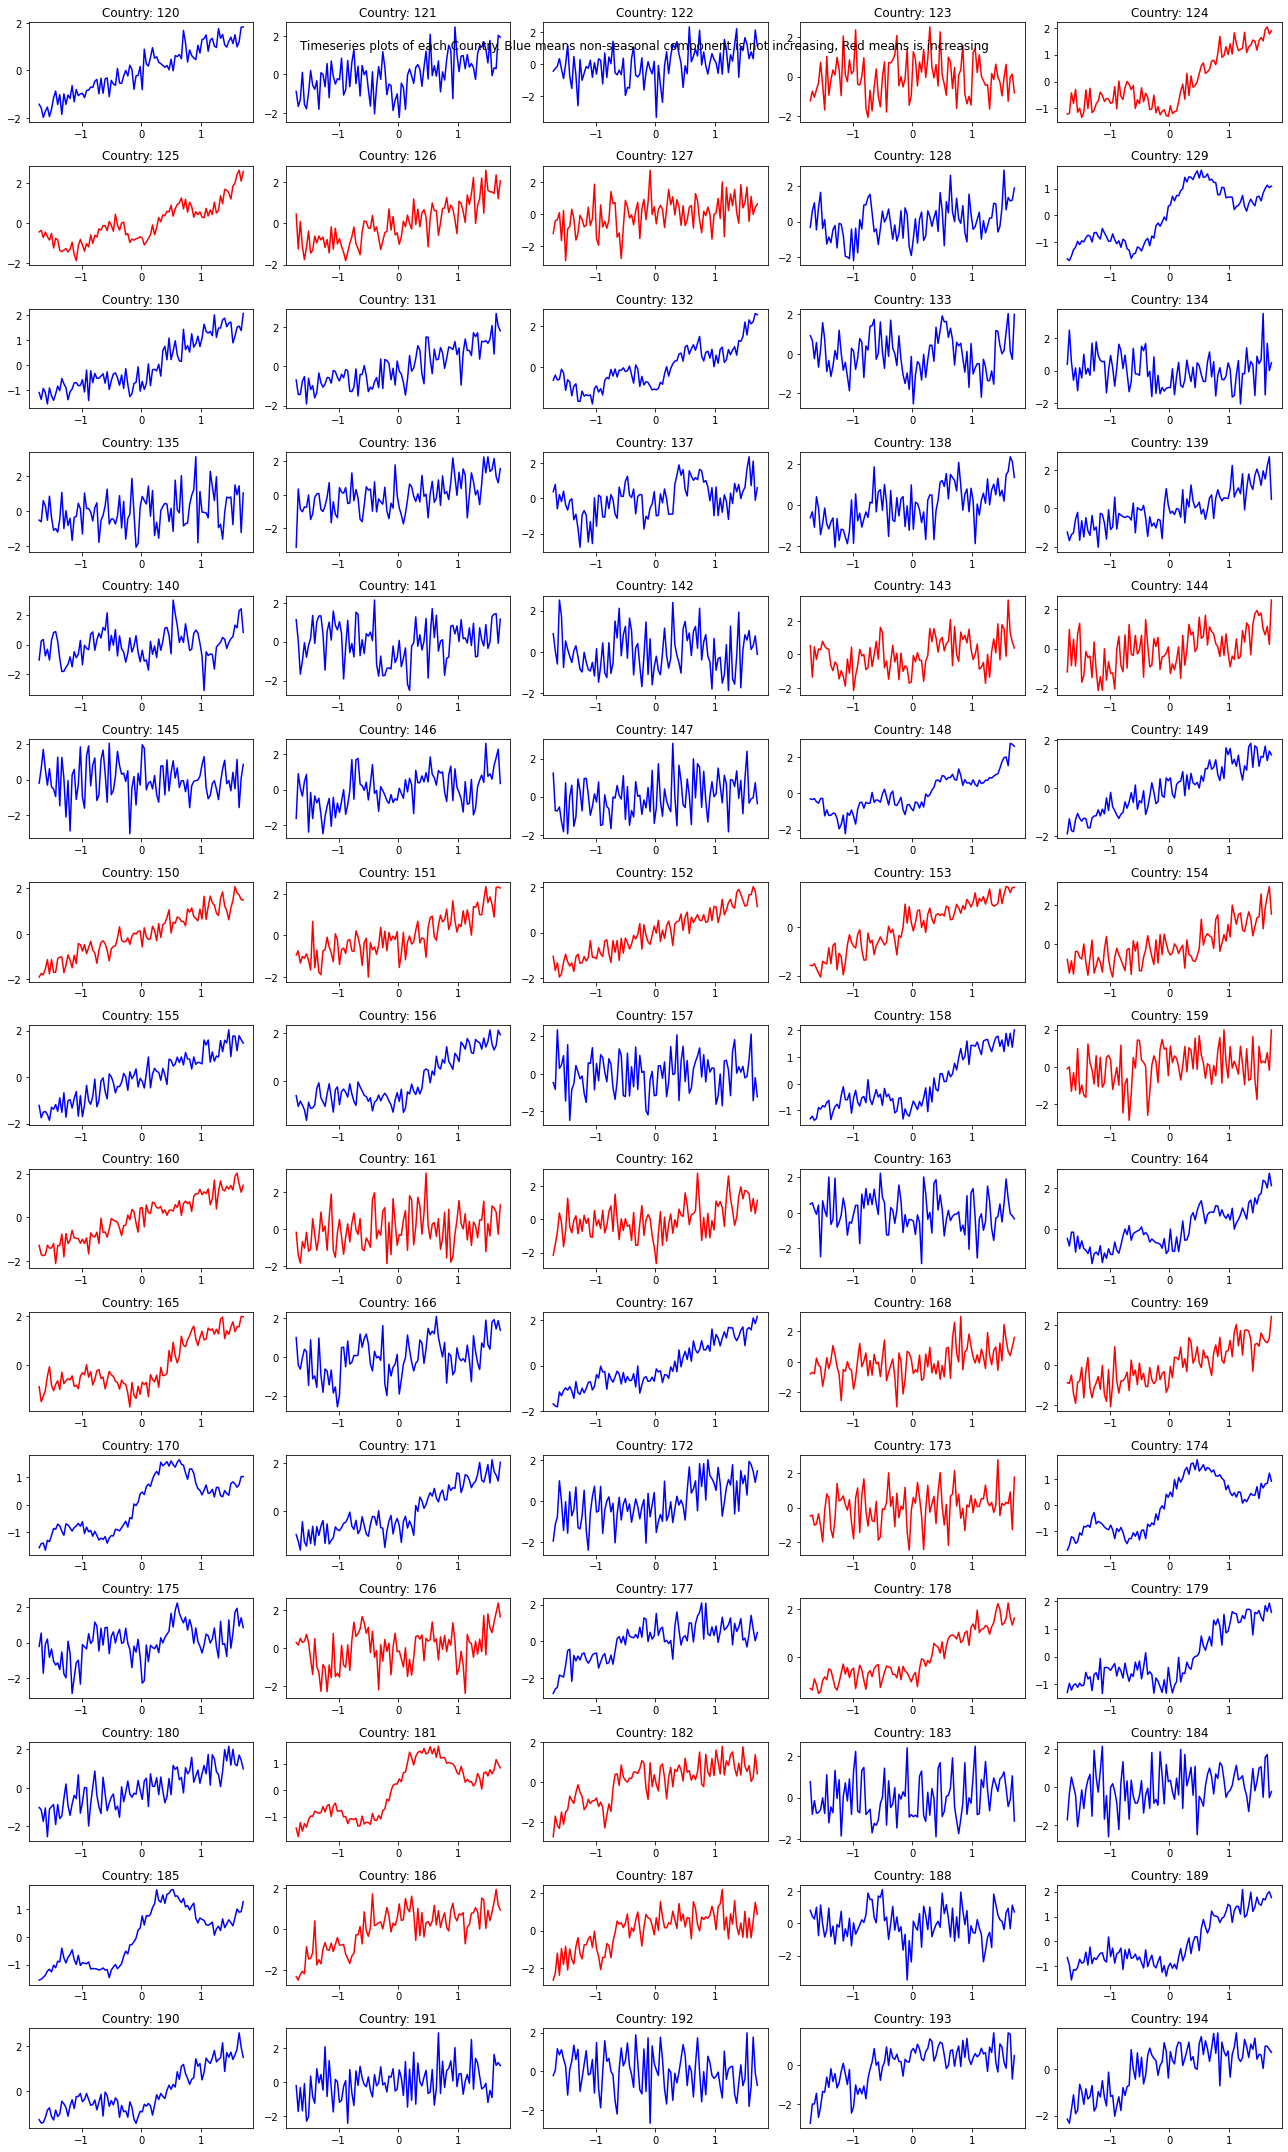

In [154]:
plot_num_cols = 5
fig, axs = plt.subplots(nrows=15, ncols=plot_num_cols, figsize=(18, 30))
axs = axs.flat # so only 1 for loop

rows = range(len(y_n))


for ax, i in zip(axs, rows):
    plt_col = i % plot_num_cols
    plt_row = i - plt_col
    ax.set_title(f'Country: {i + 120}')
    c = 'blue' if (train_df.iloc[i,-1:]['Category'] < 0.5) else 'red'
    
    ax.plot(X_n, y_n[i],color=c)
#print(y_n)

plt.tight_layout()
plt.suptitle("Timeseries plots of each Country. Blue means non-seasonal component is not increasing, Red means is increasing")
plt.show()

In [155]:
with pm.Model() as model:
    #  generic component x 
    η_s = pm.HalfCauchy("η_s", beta=5, testval=1)
    ℓ_smooth = pm.Gamma("ℓ_smooth ", alpha=1, beta=1 )
    cov_generic = η_s**2 * pm.gp.cov.ExpQuad(1,  ℓ_smooth)     
    gp1 = pm.gp.Marginal(cov_func=cov_generic)

    #  periodic component x 
    η_per = pm.HalfCauchy("η_per", beta=5, testval=1)
    #period  = pm.Normal("period", mu=1, sigma=2)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=1, beta=1)
    cov_seasonal = η_per**2 * pm.gp.cov.Cosine(1,  ℓ_psmooth)     
    gp2 = pm.gp.Marginal(cov_func=cov_seasonal)

    #  linear component x 
    tau = pm.HalfCauchy("tau", beta=2,  testval=1)
    #c0  = pm.HalfCauchy("c0", beta=2, testval=1.0)   
    c  = pm.Normal("c", mu=0, sigma=1) 
    cov_linear = tau * pm.gp.cov.Linear(1, c)     
    gp3 = pm.gp.Marginal(cov_func=cov_linear)



    # gp represents f1 + f2 + f3.
    gp =  gp1+gp2 +gp3


    # noise model
    sigma = pm.HalfCauchy("sigma", beta=5, testval=0.5)
    #f.append(gp.marginal_likelihood("f", X_n, y_n[i][:,0], noise=sigma))

    # this line calls an optimizer to optimize the marginal likelihood
    mp = pm.find_MAP(include_transformed=True)

In [156]:
# with pm.Model() as model:
#     #  periodic component x 
#     η_per = pm.HalfCauchy("η_per", beta=2, testval=1.0)
#     period  = pm.Normal("period", mu=1, sigma=3)
#     ℓ_psmooth = pm.Gamma("ℓ_psmooth ", alpha=1, beta=1)
    
#     cov_seasonal = η_per**2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth)     
#     gp1 = pm.gp.Marginal(cov_func=cov_seasonal)
    
#     #  linear component x 
#     tau = pm.HalfCauchy("tau", beta=2, testval=1.0)
#     c  = pm.Normal("c", mu=0, sigma=1) 
    
#     cov_linear = tau * pm.gp.cov.Linear(1, c)     
#     gp2 = pm.gp.Marginal(cov_func=cov_linear)
    
   

     # gp represents f1 + f2.
#     gp = gp1 + gp2
    

#     # noise model
#     sigma = pm.HalfCauchy("sigma", beta=5, testval=0.1)
#     f = gp.marginal_likelihood("f", X_n, y_n[i][:,0], noise=sigma)
    
#     # this line calls an optimizer to optimize the marginal likelihood
#     mp = pm.find_MAP(include_transformed=True)

In [157]:
#optimized parameters
sorted([name+":"+str(mp[name]) for name in mp.keys() if not name.endswith("_")])

['c:0.0',
 'sigma:0.004840431634993523',
 'tau:0.0025775046375725178',
 'η_per:0.00517326997011421',
 'η_s:0.00517326997011421',
 'ℓ_psmooth :7.400597245623401e-06',
 'ℓ_smooth :7.400597245623401e-06']

In [158]:
print(y_n[1][:,0])

[-0.8900822  -1.66167259 -1.31707259  0.10399152 -1.56220502 -1.78846716
 -0.96145973  0.19543897 -0.56519415 -0.77238976 -0.32958005 -1.81115249
  0.08084419  0.00432286 -0.64273281  0.55818971 -1.21143832  0.69221996
 -0.10712482 -0.50320771 -0.22383272 -0.28347305  0.84024308 -1.07107761
 -0.79827703  0.71548415 -0.64436895  0.61156318  1.28125951 -0.47954355
  0.42179517 -1.12302649  0.46185147 -0.01928571  0.18963602 -0.77040259
 -1.64747716  0.13419221 -2.04639358 -0.61862073  0.40048549 -0.2605767
  1.17728868  0.37491438 -1.05615238 -0.50659232 -0.5836409  -1.87585079
 -1.33846819 -1.01227606 -2.2303704  -0.46084347 -0.6754534  -1.8258848
 -0.03892884  0.27639392 -0.07327204 -0.47114202  0.36131885  0.50333713
  0.25942087 -0.62056529  0.36722072  1.20011469 -0.23905457  2.0739277
 -0.06815843  0.44908209 -0.09458319  0.69783705 -0.90822334  0.12884413
 -0.29541194  0.76214978  1.50902504  1.24309571 -1.25880099  2.45813671
  1.01732177  0.14052118  0.94150931  0.97634651  0.28

In [159]:
# 200 new values from x=0 to x=3
n_new = 100
X_new = (np.linspace(0, 1, n_new)[:,None]-np.mean(x))/np.std(x)

f1_pred=[]
y1_pred=[]
f2_pred=[]
y2_pred=[]
f3_pred=[]
y3_pred=[]
f_pred=[]
y_pred=[]

for i in range(len(y_n)):
    #generic term
    f1_pred.append(gp1.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[i][:,0], "noise": sigma}))
    y1_pred.append(gp1.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[i][:,0], "noise": sigma}, pred_noise=True))
    #periodic term
    f2_pred.append(gp2.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[i][:,0], "noise": sigma}))
    y2_pred.append(gp2.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[i][:,0], "noise": sigma}, pred_noise=True))
    #linear term
    f3_pred.append(gp3.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[i][:,0], "noise": sigma}))
    y3_pred.append(gp3.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[i][:,0], "noise": sigma}, pred_noise=True))
    #sum of periodic and linear term
    y_pred.append(gp.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[i][:,0], "noise": sigma}, pred_noise=True))
    f_pred.append(gp.predict(X_new, point=mp, given={"gp": gp, "X": X_n, "y": y_n[i][:,0], "noise": sigma}))
    
# for i in range(len(y)):
#     #generic term
#     f1_pred.append(gp1.predict(X_new, point=mp, given={"gp": gp, "X": x, "y": y, "noise": sigma}))
#     y1_pred.append(gp1.predict(X_new, point=mp, given={"gp": gp, "X": x, "y": y[i][:,0], "noise": sigma}, pred_noise=True))
#     #periodic term
#     f2_pred.append(gp2.predict(X_new, point=mp, given={"gp": gp, "X": x, "y": y[i][:,0], "noise": sigma}))
#     y2_pred.append(gp2.predict(X_new, point=mp, given={"gp": gp, "X": x, "y": y[i][:,0], "noise": sigma}, pred_noise=True))
#     #linear term
#     f3_pred.append(gp3.predict(X_new, point=mp, given={"gp": gp, "X": x, "y": y[i][:,0], "noise": sigma}))
#     y3_pred.append(gp3.predict(X_new, point=mp, given={"gp": gp, "X": x, "y": y[i][:,0], "noise": sigma}, pred_noise=True))
#     #sum of periodic and linear term
#     y_pred.append(gp.predict(X_new, point=mp, given={"gp": gp, "X": x, "y": y[i][:,0], "noise": sigma}, pred_noise=True))
#     f_pred.append(gp.predict(X_new, point=mp, given={"gp": gp, "X": x, "y": y[i][:,0], "noise": sigma}))

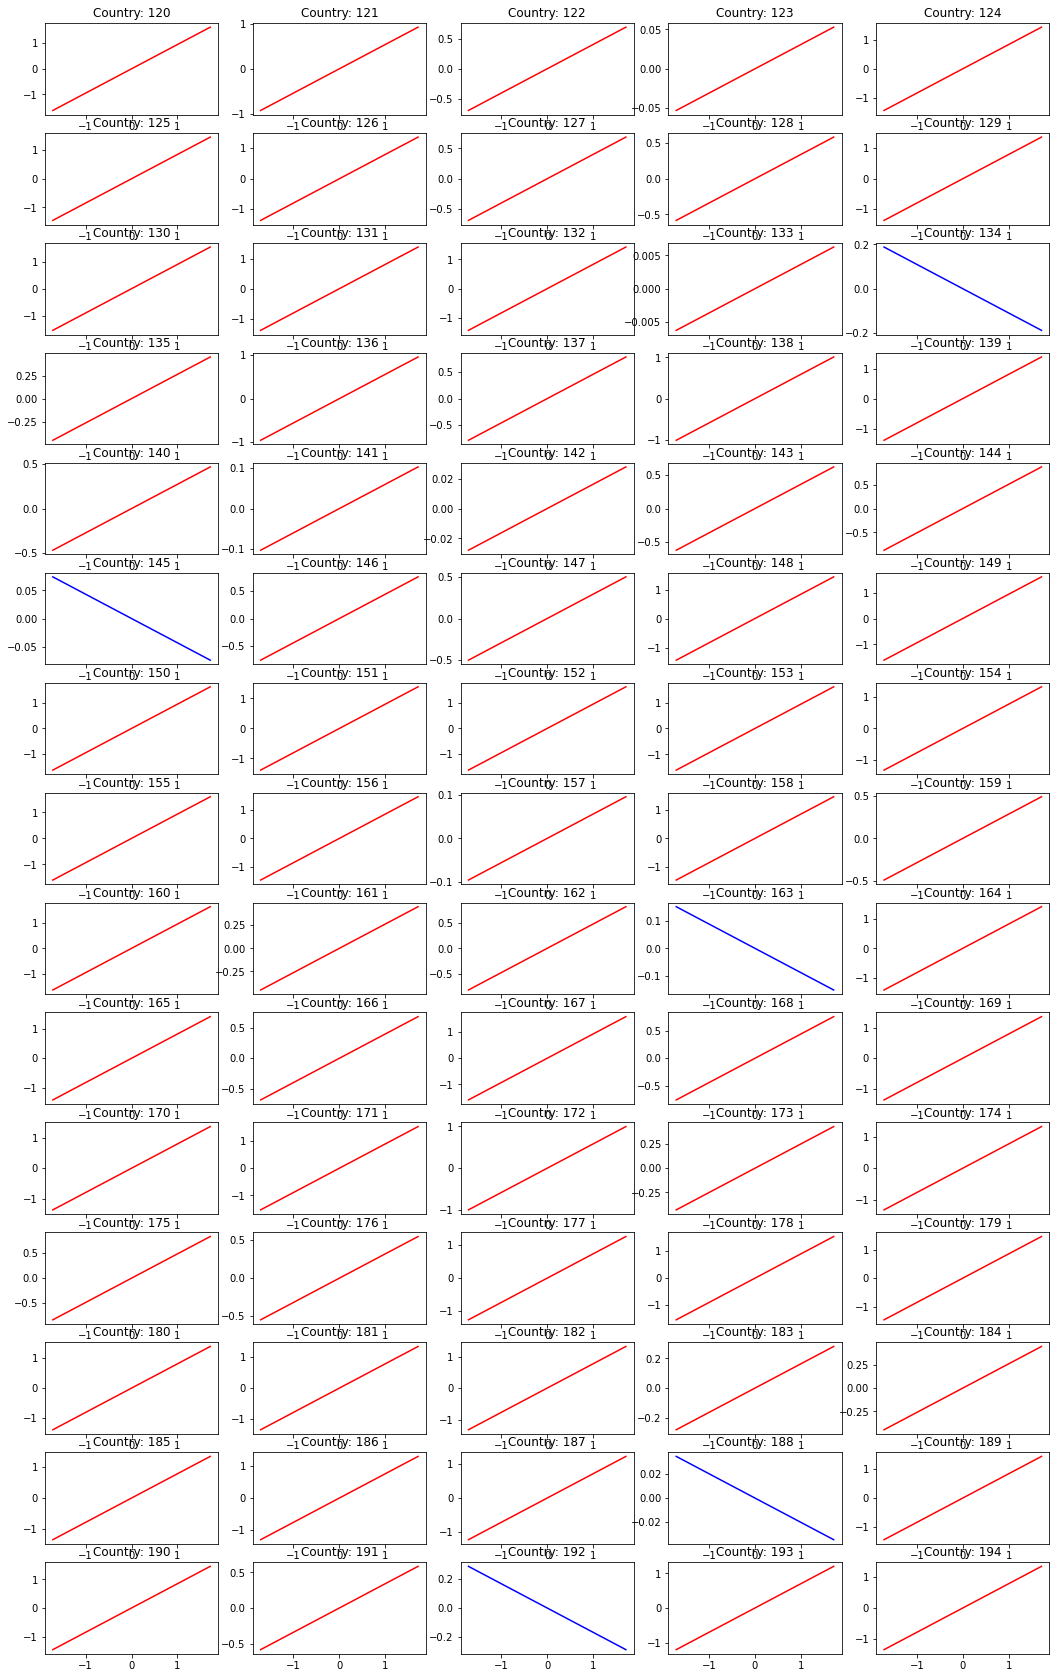

In [163]:
from scipy.stats import linregress
plot_num_cols = 5
fig, axs = plt.subplots(nrows=15, ncols=plot_num_cols, figsize=(18, 30))
axs = axs.flat # so only 1 for loop
m = []
rows = range(len(y_n))
for ax, i in zip(axs, rows):
    plt_col = i % plot_num_cols
    plt_row = i - plt_col
    ax.set_title(f'Country: {i + 120}')
    slope, intercept, r_value, p_value, std_err = linregress(X_new[:,0], f3_pred[i][0])
    m.append(slope)
    c = 'blue' if (slope < 0) else 'red'
    ax.plot(X_new[:,0],f3_pred[i][0],label="linear",color=c)

In [164]:
for i in range(len(m)):
    id_row = test_df.iloc[i,0]
    if m[i]>0:
        decision = 1
    else:
        decision = 0
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
    Decision.to_csv("Decision_baseline.csv",  index=False)